In [5]:
!pip install lm_eval
!pip install matplotlib

In [6]:
%cd /workspace/
%env NCCL_P2P_DISABLE="1" 
%env NCCL_IB_DISABLE="1"

import json

import lm_eval
import torch
import torch.nn.functional as F
from lm_eval.api.model import LM
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from model import GPT, get_model_config
from tokenizer import LinearTokenizer
from tokenizers import Tokenizer
    
# lm_eval --model hf --model_args pretrained=openai-community/gpt2 --tasks hellaswag --device cuda:0 --batch_size 8

/workspace
env: NCCL_P2P_DISABLE="1"
env: NCCL_IB_DISABLE="1"


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
class LMWrapper(LM):
    def __init__(self, tokenizer, model, device='cuda'):
        super().__init__()
        self.device = device
        self.tokenizer = tokenizer
        self.model = model.to(self.device)

    def loglikelihood(self, requests, disable_tqdm: bool = False):
        return [self.calculate_loglikelihood(req.arguments[0], req.arguments[1]) for req in tqdm(requests, disable=disable_tqdm)]

    def calculate_loglikelihood(self, context, continuation):
        input_text = context + continuation
        inputs = self.tokenizer.encode(input_text)
        inputs = torch.tensor(inputs, dtype=torch.long).unsqueeze(0).to(self.device)
        model_inputs = inputs[:, :-1]

        continuation_ids = self.tokenizer.encode(continuation)
        continuation_ids = torch.tensor(continuation_ids, dtype=torch.long).unsqueeze(0).to(self.device)

        with torch.no_grad():
            ret = self.model(model_inputs)
            logits = ret[0] if isinstance(ret, tuple) else ret.logits # get logits from nanoGPT/hf model

        continuation_length = continuation_ids.size(-1)
        continuation_logits = logits[:, -continuation_length:]
        loss = F.cross_entropy(continuation_logits.view(-1, continuation_logits.size(-1)), continuation_ids.view(-1), reduction="sum")
        log_likelihood = -loss.item()

        greedy_ids = torch.argmax(continuation_logits, dim=-1)
        is_greedy = torch.equal(greedy_ids, continuation_ids)
        
        return (log_likelihood, is_greedy)

    def generate_until(self, requests):
        raise NotImplementedError()
    
    def loglikelihood_rolling(self, requests):
        raise NotImplementedError()


def create_lm_hf(model_type="gpt2"):
    tokenizer = AutoTokenizer.from_pretrained('gpt2')
    model = AutoModelForCausalLM.from_pretrained(model_type)
    return LMWrapper(tokenizer, model, device="cuda")


def create_lm(model_type, tokenizer_type, checkpoint_path, vocab_size=50304):
    model = GPT(get_model_config(model_type, vocab_size=vocab_size))
    model.load_state_dict(torch.load(checkpoint_path, weights_only=False)["model"])

    assert tokenizer_type in ["bpe", "lin"], "tokenizer must either be bpe or lin"
    if tokenizer_type == "bpe":
        tokenizer = AutoTokenizer.from_pretrained('gpt2')#
    if tokenizer_type == "lin":
        with open('./vocab.json', 'r', encoding='utf-8') as f:
            vocab = json.load(f)
        tokenizer = LinearTokenizer(vocab)

    return LMWrapper(tokenizer, model, device="cuda")

In [8]:
models = {
    # "bpe-hf": create_lm_hf(),
    #"bpe-0": create_lm("gpt2", "bpe", "models-linear/model-bpe-05-11.pt", vocab_size=50257),
    #"bpe-1": create_lm("gpt2", "bpe", "models-linear/model-bpe-08-11.pt"),
    #"lin-0": create_lm("gpt2", "lin", "models-linear/model-lin-05-11.pt", vocab_size=50257),
    #"lin-1": create_lm("gpt2", "lin", "models-linear/model-lin-08-11.pt"),
    #"bpe-md-0": create_lm("gpt2-medium", "bpe", "models-linear/model-bpe-md-08-11.pt"),
    "lin-md-0": create_lm("gpt2-medium", "lin", "models-linear/model-lin-md-08-11.pt"),
}

results = {}
for name, model in models.items():
    task_manager = lm_eval.tasks.TaskManager()
    model_result = lm_eval.simple_evaluate(
        model=model,
        # "hellaswag", "piqa", "arc_easy", "winogrande", "lambada_openai"
        tasks=["hellaswag", "piqa", "arc_easy", "winogrande", "lambada_openai"],
        task_manager=task_manager,
        # num_fewshot=None,
        # limit=None,
    )

    print(name)
    print(model_result["results"])
    results[name] = model_result["results"]

    with open("eval.json", "w") as json_file:
        json.dump(results, json_file, indent=4)

2024-11-09:03:13:13,763 INFO     [evaluator.py:164] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2024-11-09:03:13:13,764 INFO     [evaluator.py:217] Using pre-initialized model
2024-11-09:03:13:38,403 WARNING  [task.py:325] [Task: lambada_openai] has_training_docs and has_validation_docs are False, using test_docs as fewshot_docs but this is not recommended.
2024-11-09:03:13:38,405 WARNING  [task.py:325] [Task: lambada_openai] has_training_docs and has_validation_docs are False, using test_docs as fewshot_docs but this is not recommended.
2024-11-09:03:13:38,589 INFO     [task.py:415] Building contexts for lambada_openai on rank 0...
100%|██████████| 5153/5153 [00:12<00:00, 404.68it/s]
2024-11-09:03:13:51,490 INFO     [task.py:415] Building contexts for winogrande on rank 0...
100%|██████████| 1267/1267 [00:00<00:00, 48541.99it/s]
2024-11-09:03:13:51,607 INFO     [task.py:415] Building contexts for arc_e

bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:08<00:00, 11.72it/s]
fatal: not a git repository (or any of the parent directories): .git


lin-md-0
{'arc_easy': {'alias': 'arc_easy', 'acc,none': 0.5526094276094277, 'acc_stderr,none': 0.010202832385415639, 'acc_norm,none': 0.49452861952861954, 'acc_norm_stderr,none': 0.010259169228615044}, 'hellaswag': {'alias': 'hellaswag', 'acc,none': 0.3064130651264688, 'acc_stderr,none': 0.0046006120004226676, 'acc_norm,none': 0.3509261103365863, 'acc_norm_stderr,none': 0.004762844770909871}, 'lambada_openai': {'alias': 'lambada_openai', 'perplexity,none': 75.70471584899612, 'perplexity_stderr,none': 3.3801848863491366, 'acc,none': 0.27168639627401514, 'acc_stderr,none': 0.006197338676240231}, 'piqa': {'alias': 'piqa', 'acc,none': 0.6490750816104461, 'acc_stderr,none': 0.011135250564776798, 'acc_norm,none': 0.6360174102285092, 'acc_norm_stderr,none': 0.011225875703487171}, 'winogrande': {'alias': 'winogrande', 'acc,none': 0.5074980268350434, 'acc_stderr,none': 0.014050905521228587}}


model        bpe-0    bpe-1    lin-0    lin-1
measure   acc_norm acc_norm acc_norm acc_norm
task                                         
arc_easy    0.4785   0.4646   0.4609   0.4701
hellaswag   0.3193   0.3243   0.3274   0.3256
piqa        0.6197   0.6246   0.6240   0.6240


<Figure size 1000x600 with 0 Axes>

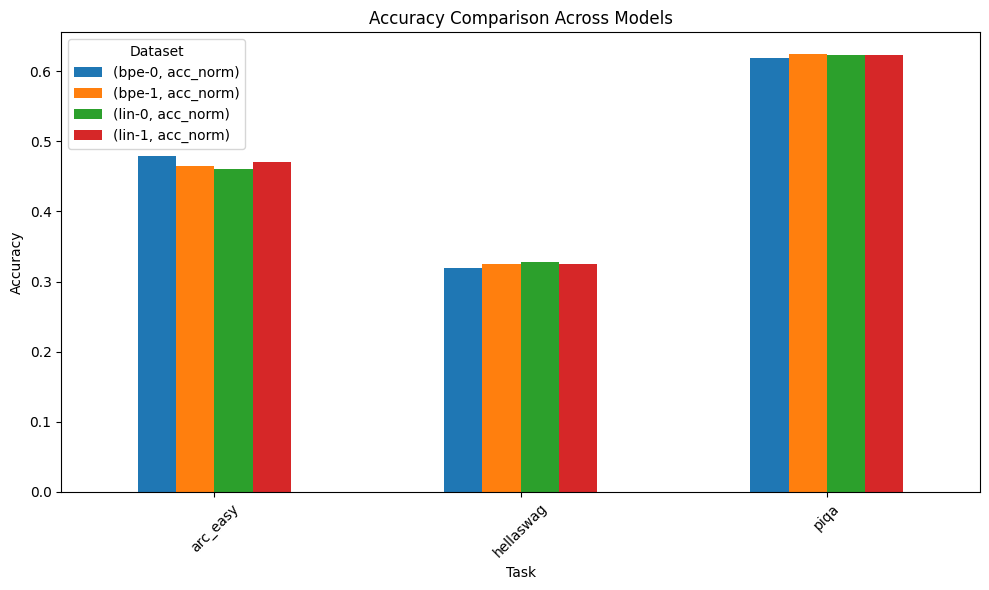

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import json

pd.set_option('display.max_colwidth', 200)

with open('/workspace/eval.json', 'r') as file:
    data = json.load(file)

df = pd.json_normalize(data, sep='|').T
df.reset_index(inplace=True)
df.columns = ['metric', 'value']

df['metric'] = df['metric'].str.replace(',none', '')

df[['model', 'task', 'measure']] = df['metric'].str.split('|', expand=True)
df = df.drop(columns='metric')

df = df[~df['model'].isin(['bpe-md-0', 'lin-md-0'])]
df = df[~df['task'].isin(['winogrande'])]
df = df[df['measure'].isin(['acc_norm'])]

accuracy_pivot = df.pivot(index='task', columns=['model', 'measure'], values='value')
# print(accuracy_df)
with pd.option_context('display.float_format', '{:.4f}'.format):
    print(accuracy_pivot.to_string())

plt.figure(figsize=(10, 6))
accuracy_pivot.plot(kind='bar', figsize=(10, 6), rot=45)
plt.title('Accuracy Comparison Across Models')
plt.ylabel('Accuracy')
plt.xlabel('Task')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()